# This is a notebook that demonstrates how to generate one of the zodipics

The first step is to import all the base libraries that will be needed.

In [1]:
import astropy.io.fits as fits
import astropy.units as u
import os
import numpy as np
import matplotlib.pyplot as plt
import time # for timing purposes
from scipy.interpolate import RegularGridInterpolator
from pathlib import Path

from importlib import reload

Also update the parameters for plots so that viewing and analyzing plots is more intuitive.

In [2]:
plt.rcParams.update({'image.origin': 'lower',
                     'image.interpolation':"nearest"})

Next is to import the python files that contain all the functions used to process the zodipics and Debes Models. The functions used are also displayed at the bottom of the code but are contained in a separate .py file so that use would be easier. 

In [3]:
import hlc_processing
import disk_processing

Next is to setup the home path where all the files needed.

In [4]:
my_home_path = Path(os.getcwd())
print(my_home_path)

C:\Users\Kian\Documents\GitHub\ProcessZodipicsRepo


### Then import the fits files that contain the psfs and the information about the psfs such as the offset values
In this case, the psfs used for the demonstration will be the Observing Sceneario 5 psfs which are publicly available on the wfirst ipac website.

In [5]:
# first, define the paths of each of the files 

psfs_file_path = my_home_path /'offset_psfs'/'OS5_ADI_3.2'/'OS5_adi_3_highres_polx_lowfc_random_offset_psfs.fits'
print(psfs_file_path)

info_file_path = my_home_path /'offset_psfs'/'OS5_ADI_3.2'/'OS5_adi_3_highres_polx_lowfc_random_offset_psfs_offsets.fits'
print(info_file_path)

# for these psfs, the info file just contains the offset values for the psfs

C:\Users\Kian\Documents\GitHub\ProcessZodipicsRepo\offset_psfs\OS5_ADI_3.2\OS5_adi_3_highres_polx_lowfc_random_offset_psfs.fits
C:\Users\Kian\Documents\GitHub\ProcessZodipicsRepo\offset_psfs\OS5_ADI_3.2\OS5_adi_3_highres_polx_lowfc_random_offset_psfs_offsets.fits


In [6]:
# open the fits files using the astropy.fits library and obtain the headers

psfs_file = fits.open(psfs_file_path)
info_file = fits.open(info_file_path)

psfs_header = psfs_file[0].header
info_header = info_file[0].header

In [7]:
# print what the headers of the files are to see what information can be used directly from the headers

for i,descriptor in enumerate(psfs_header,1):
    print(i, descriptor, psfs_header[descriptor])

print('\n')

for i,descriptor in enumerate(info_header,1):
    print(i, descriptor, info_header[descriptor])

1 SIMPLE True
2 BITPIX -64
3 NAXIS 3
4 NAXIS1 217
5 NAXIS2 217
6 NAXIS3 18
7 DATE 2016-06-03
8 LAM_C 550.0
9 MINLAM 508.8
10 MAXLAM 591.3
11 PIX_AS 0.00476662
12 PIX_LD 0.1


1 SIMPLE True
2 BITPIX -32
3 NAXIS 1
4 NAXIS1 18
5 EXTEND True
6 DATE 2016-06-03


From the headers, we see that there are 18 psfs and each psf is 217 by 217 pixels. Also, we are given the piel scale both in terms of arcseconds and in terms of lambda/D with lambda being the central wavelength, which for these psfs is 550nm.

First, set the psfs data to the variable psfs, then check the shape of psfs data since it is a datacube to find 
which axis is the one that represents which psfs out of the 18 it is.

In [8]:
psfs = psfs_file[0].data
print(psfs.shape)

(18, 217, 217)


Because the psfs are 217 by 217 pixels, each psf needs to be trimmed to be 200 by 200. In order to do this, remove 8 pixels from the left and 9 pixels from the right and now that we know what the axis are, just manipulate the data as a numpy area to remove the pixels.

In [9]:
trimmed_psfs = psfs[:,8:-9,8:-9]

Now, move the axis of the data so that the 3rd axis is the one that represents which psf it is. This is important for creating the interpolating function that will interpolate over a grid using x,y,z coordinates.

(200, 200, 18)


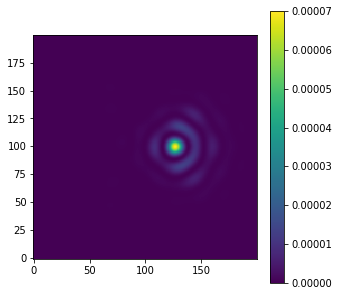

In [10]:
trimmed_moved_psfs = np.moveaxis(trimmed_psfs,0,-1)
print(trimmed_moved_psfs.shape)

# plot a psf to check if it looks correct
psf_num = 3
plt.figure(figsize=[5,5])
plt.imshow(trimmed_moved_psfs[:,:,psf_num])
plt.colorbar()

Now setup the offset values of the psfs using the info fits file. The info fits file gives the offset values in terms of lambda/D so these need to be converted into milliarcseconds. 

In [11]:
offsets_LD = info_file[0].data

lambda_c = psfs_header['LAM_C']*u.nm
D = 2.4*u.m # the estimated diameter of the telescope; not given in the headers
lambda_D = lambda_c.to(u.m)/D

offsets_rad = offsets_LD*lambda_D.value*u.radian
offsets_mas = offsets_rad.to(u.mas)
print(offsets_mas)

[  0.        42.542118  99.26493  113.44565  127.62636  155.98776
 170.16847  184.34917  212.71057  226.8913   255.25272  283.6141
 340.33694  382.87906  397.05972  411.24045  425.42114  439.60187 ] mas


Now set the plate scale of the detector using the information given from the header.

In [12]:
HLC_plate_scale_LD = psfs_header["PIX_LD"] # arcsec/pixel of HLC PSFs
print(HLC_plate_scale_LD)

HLC_plate_scale_AS = psfs_header["PIX_AS"]*u.arcsec # arcsec/pixel of HLC PSFs
print(HLC_plate_scale_AS)

0.1
0.00476662 arcsec


Now to setup the interpolating function using the RegularGridInterpolator from scipy.

In [13]:
n = 200 # this is how many pixels are in the grid that will be interpolated over

x = range(n)
y = range(n)
z = offsets_mas

hlcpsfs = trimmed_moved_psfs # set the trimmed and moved psfs to hlcpsfs here so it will be easier to use in the code

my_interpolating_function = RegularGridInterpolator((x, y, z), 
                                                    hlcpsfs,
                                                    bounds_error = False,
                                                    method = "linear",
                                                    fill_value = 0)

# either nearest or linear interpolation can be used but linear will be more accurate


Do an example interpolation to check the interpolating function.

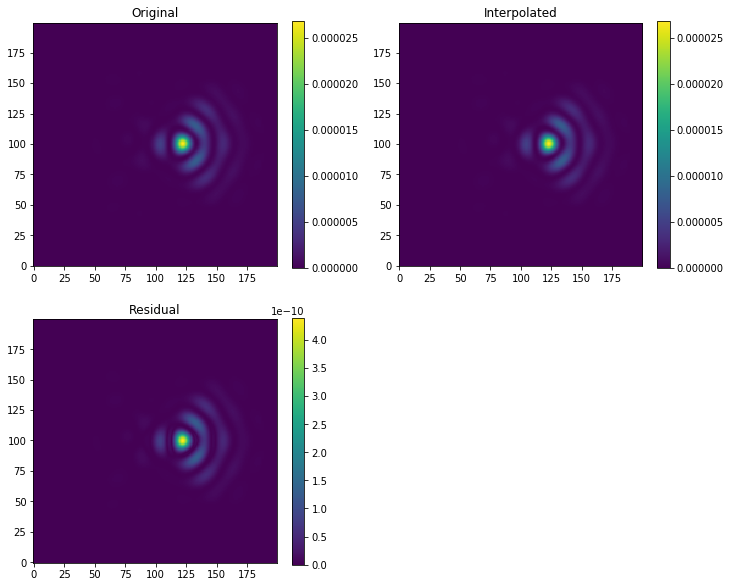

In [14]:
n = 200 

x = range(n)
y = range(n)

grid = np.meshgrid(x,y) # create the grid to be interpolated over
flattened_grid = np.vstack([grid[0].flatten(),grid[1].flatten()]) # flatten each dimension of the grid and stack the vectors
offset = 99.264
'''
set the offset value that will be interpolated, if the offset is exactly the same as one of the 
offset values in the array of offsets, then the residual should just be 0
'''
pts = np.vstack( [flattened_grid, offset*np.ones(len(grid[0].flatten()))] ) # create the set of points with that offset
pts = pts.T 

nearest_psf = (np.abs(offsets_mas.value - offset)).argmin()

interpped = my_interpolating_function(pts).reshape(n,n).T

# Now display everything
plt.figure(figsize=[12,10])

# Plot the original PSF
plt.subplot(221)
plt.title("Original")
plt.imshow(hlcpsfs[:,:,nearest_psf])
plt.colorbar()
# Plot the interpolated PSF
plt.subplot(222)
plt.title("Interpolated")
plt.imshow(interpped)
plt.colorbar()
# Plot the inerpolated - original PSF
plt.subplot(223)
plt.title("Residual")
plt.imshow(np.abs(interpped-hlcpsfs[:,:,nearest_psf]))
plt.colorbar()

Now create an image of a point source, in this case called a planet, using the the interpolating function and the function closest_monochrome_psf.

How closest_monochrome_psf works: 
1. First, the x,y values are converted to r,theta values.
2. Next, a set of pts is created using a flattened meshgrid and the r value (the same thing that was done for the planet interpolation example in this code except the r value acts as the offset value)
3. Then, the interpolation is done using the interpolation function created to find what the psf with that offset value would be just like the example interpolation done directly in this code. 
4. Lastly, there is an extra step which is because the point will have a theta value along with the offset, so the array is then rotated using that theta value with the rotate function from scipy.ndimage
    

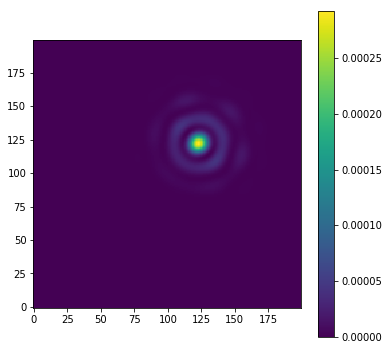

In [15]:
reload(hlc_processing)
x_offset = 100*u.milliarcsecond
y_offset = 100*u.milliarcsecond
planet = hlc_processing.closest_monochrome_PSF(x_offset,y_offset,
                                               my_interpolating_function,
                                               offsets_mas,
                                               HLC_plate_scale_AS,
                                               mask_radius = None)

plt.figure(figsize=[6,6])
plt.imshow(planet)
plt.colorbar()

Now, create the paths that will be used to open and save the zodipics files.

In [16]:
zodi_input_path = my_home_path/"zodipics"
print(zodi_input_path)

zodi_output_path = my_home_path/'zodipics_outputs'/'zodipic_10pc03mas01alpha'
print(zodi_output_path)
# there is a folder for each of the zodipics inside the zodipics_outputs folder so change the 
# last folder name depending on which zodipic is being used

zodi_header = psfs_header # make the zodi_header the psfs_header

C:\Users\Kian\Documents\GitHub\ProcessZodipicsRepo\zodipics
C:\Users\Kian\Documents\GitHub\ProcessZodipicsRepo\zodipics_outputs\zodipic_10pc03mas01alpha


Now to run one of the zodipics which are all 256 by 256 pixels. The file being used is the zodipic_10pc03mas01alpha and the file will be run twice, once without a coremask and once with a coremask. In order to run the file, it goes through a function from hlc_processing called fit_to_hlc.

How fit_to_hlc works: 

1. First, it creates masked array of the zodi data based on if the zodi value in a pixel is less than the max divided by the thresh. 
2. Then, it creates a 256 by 256 grid ranging from -128 to 127 to represent the pixel grid.
3. Next, because there are an even number of pixels, it does half pixel shifts to center the x,y grid and multiply by the pixel scale to create the x,y grid in arcseconds. 
4. Then, it adjusts the masked array based on the core mask radius. 
5. Flattens the pixel grid and initializes the im which will be 200 by 200. 
6. Lastly, there is a for loop which runs through the data in the zodi masked array. 
If the value is masked, then the loop does nothing and continues to the next value. 
If the value is not masked, then the loop creates an im using the zodi_val as a weight and by calling the closest_monochrome_psf function with the corresponding x,y to that zodi_val. 
Each time a loop is completed, the im summed up again.

Running zodipic through HLC ...

Input file: 
C:\Users\Kian\Documents\GitHub\ProcessZodipicsRepo\zodipics\zodipic_10pc03mas01alpha.fits
C:\Users\Kian\Documents\GitHub\ProcessZodipicsRepo\zodipics_outputs\zodipic_10pc03mas01alpha\zodipic_10pc03mas01alpha_HLC.fits
C:\Users\Kian\Documents\GitHub\ProcessZodipicsRepo\zodipics_outputs\zodipic_10pc03mas01alpha\zodipic_10pc03mas01alpha_input.fits
1267.353332042694


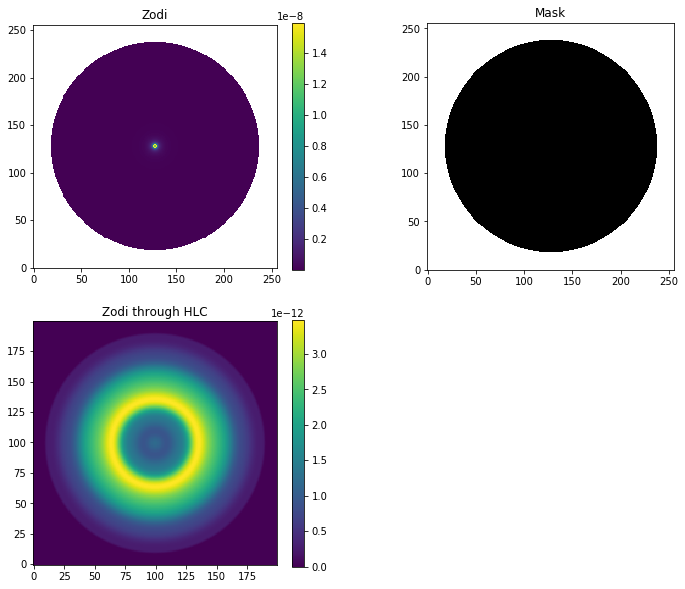

In [18]:
reload(hlc_processing)

zodi_fname = "zodipic_10pc03mas01alpha.fits"
zodi_file = zodi_input_path/zodi_fname

# set the thresh value
thresh = 1e32

# first run it without a coremask
core_mask_radius=0*u.arcsec

start = time.time()

im,zodi = hlc_processing.fit_to_hlc(zodi_file,
                                    my_interpolating_function,
                                    offsets_mas,
                                    HLC_plate_scale_AS,
                                    n = 200,
                                    thresh = thresh,
                                    display=True, 
                                    core_mask_radius = core_mask_radius)

# create the names of the files that will be saved
im_name = zodi_output_path/(zodi_fname[:-5] + "_HLC.fits")
print(im_name)

zodi_name = zodi_output_path/(zodi_fname[:-5] + "_input.fits")
print(zodi_name)

# set the header of the files that will be saved
zodi_header["thresh"] = thresh
zodi_header["coremask"] = core_mask_radius.value

fits.writeto(im_name, im, overwrite=True, header=zodi_header) 
fits.writeto(zodi_name, zodi.filled(fill_value = 0), overwrite = True)

end = time.time()
print(end-start)

Running zodipic through HLC ...

Input file: 
C:\Users\Kian\Documents\GitHub\ProcessZodipicsRepo\zodipics\zodipic_10pc03mas01alpha.fits
C:\Users\Kian\Documents\GitHub\ProcessZodipicsRepo\zodipics_outputs\zodipic_10pc03mas01alpha\zodipic_10pc03mas01alpha_coremasked_HLC.fits
C:\Users\Kian\Documents\GitHub\ProcessZodipicsRepo\zodipics_outputs\zodipic_10pc03mas01alpha\zodipic_10pc03mas01alpha_coremasked_input.fits
1025.3105897903442


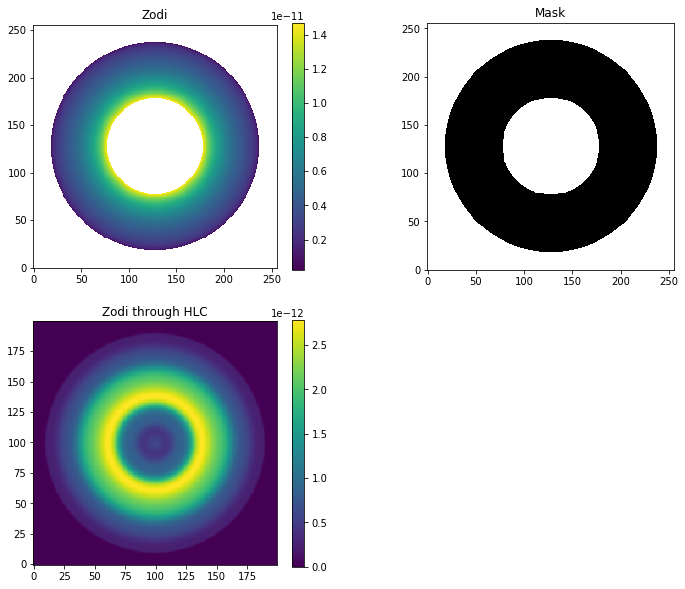

In [20]:
reload(hlc_processing)

zodi_fname = "zodipic_10pc03mas01alpha.fits"
zodi_file = zodi_input_path/zodi_fname

# set the thresh value
thresh = 1e32

# now run it with a coremask of 150mas
core_mask_radius=0.15*u.arcsec

start = time.time()

im,zodi = hlc_processing.fit_to_hlc(zodi_file,
                                    my_interpolating_function,
                                    offsets_mas,
                                    HLC_plate_scale_AS,
                                    n = 200,
                                    thresh = thresh,
                                    display=True, 
                                    core_mask_radius = core_mask_radius)

# create the names of the files that will be saved
im_name = zodi_output_path/(zodi_fname[:-5] + "_coremasked_HLC.fits")
print(im_name)

zodi_name = zodi_output_path/(zodi_fname[:-5] + "_coremasked_input.fits")
print(zodi_name)

# set the header of the files that will be saved
zodi_header["thresh"] = thresh
zodi_header["coremask"] = core_mask_radius.value

fits.writeto(im_name, im, overwrite=True, header=zodi_header) 
fits.writeto(zodi_name, zodi.filled(fill_value = 0), overwrite = True)

end = time.time()
print(end-start)

Now, create the paths that will be used to open the Debes Models files.

In [17]:
debes_input_path = my_home_path/"DebesModels"
print(debes_input_path)

C:\Users\Kian\Documents\GitHub\ProcessZodipicsRepo\DebesModels


Now run one of the files through the disk_through_hlc function which is contained in the disk_processing.py file. 

How disk_through_hlc works: (very similar to fit_to_hlc function)
1. First, the function creates the output path which the file will be saved to based on if the file is an annulus, constanttau, gap, or ring file. 
2. Then, it creates the masked array of the data based on if the value in a pixel is less than the max divided by the thresh. 
3. Next, it creates an x,y grid with the x,y in arcseconds based on the pixel scale of the fits file. 
4. Lastly, it runs the same for loop that is used in the fit_to_hlc function. As a reminder, this is what the for loop does. 
If the value is masked, then the loop does nothing and continues to the next value. 
If the value is not masked, then the loop creates an im using the zodi_val as a weight and by calling the closest_monochrome_psf function with the corresponding x,y to that zodi_val. 
Each time a loop is completed, the im summed up again.

Running disk through HLC ...

Input file: 
C:\Users\Kian\Documents\GitHub\ProcessZodipicsRepo\DebesModels\Model_Annulus\annulus_inc60_r0.4.fits

Output file: 
C:\Users\Kian\Documents\GitHub\ProcessZodipicsRepo\DebesModels_outputs\Model_Annulus\annulus_inc60_r0.4_HLC_5.fits

Thresh = 5
local zodi: 0

load_existing keyword False, throwing error to regenerate file.


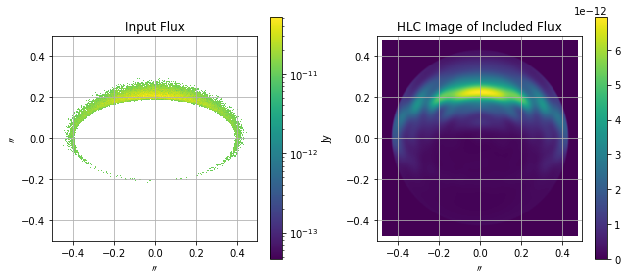

137.3083200454712


In [18]:
reload(disk_processing)

fitsfile = 'annulus_inc60_r0.4.fits'

start_time = time.time()

im,zodi,outfits = disk_processing.disk_through_hlc(fitsfile,
                                                   my_interpolating_function,
                                                   offsets_mas,
                                                   HLC_plate_scale_AS,
                                                   n = 200,
                                                   thresh=5,
                                                   display=True)

fits.writeto(outfits, im, overwrite = True)

end_time = time.time()
print(end_time-start_time)